# GPROF rain rate retrieval

In this notebook we will apply QRNNs to retrieval rain rates from passive microwave observations from the Global Precipitation Measurement (GPM) mission. We will then use the model to classify pixels based on their rain rate and compare the performance of the classifier to that of the current algorithm. 

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from quantnn.examples.gprof_rr import GPROFDataset, download_data
download_data()

## The Data

The input data consists of single-pixel observations from the GMI radiometer combined with the surface type, column-integrated water vapor and two-meter temperature. Expanding the 14 surface types to one-hot encoding results in 29 input features.

The output data consists of surface rain rates, which are, for the largest part, derived from GMI observations combined with the precipitation radar, which is flown together with GMI on board the GPM Core Observatory satellite. The combined radar-radiometer observations improve the accuracy of the rain retrieval, which is why this data is suitable to be used as ground truth.

In [2]:
training_data = GPROFDataset("data/training_data_gmi_small.nc", batch_size=128)
validation_data = GPROFDataset("data/training_data_gmi_small.nc", batch_size=128, normalizer=training_data.normalizer)

In [5]:
from torch.utils.data import DataLoader
training_loader = DataLoader(training_data, batch_size=None, num_workers=2)
validation_loader = DataLoader(validation_data, batch_size=None, num_workers=2)

## Defining a QRNN model

In [8]:
import quantnn as qn
quantiles = [0.01, 0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95, 0.99]
qrnn = qn.QRNN(n_inputs=29, quantiles=quantiles, model=(4, 256, "relu"))

## Training the QRNN

In [13]:
import torch
n_epochs = 10
optimizer = torch.optim.SGD(qrnn.model.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)
qrnn.train(training_loader,
           validation_loader,
           optimizer=optimizer,
           scheduler=scheduler,
           n_epochs=n_epochs,
           device="gpu")
optimizer = torch.optim.SGD(qrnn.model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)
qrnn.train(training_loader,
           validation_loader,
           optimizer=optimizer,
           scheduler=scheduler,
           n_epochs=n_epochs,
           device="gpu")
optimizer = torch.optim.SGD(qrnn.model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)
qrnn.train(training_loader,
           validation_loader,
           optimizer=optimizer,
           scheduler=scheduler,
           n_epochs=n_epochs,
           device="gpu")

Epoch  1 / 10: train. loss = 0.0199, val. loss = 0.0182, lr. = 0.1000, time = 59.254601 s
Epoch  2 / 10: train. loss = 0.0088, val. loss = 0.0178, lr. = 0.0976, time = 59.139654 s
Epoch  3 / 10: train. loss = 0.0057, val. loss = 0.0174, lr. = 0.0905, time = 58.889094 s
Epoch  4 / 10: train. loss = 0.0041, val. loss = 0.0171, lr. = 0.0794, time = 59.745256 s
Epoch  5 / 10: train. loss = 0.0032, val. loss = 0.0168, lr. = 0.0655, time = 59.312547 s
Epoch  6 / 10: train. loss = 0.0026, val. loss = 0.0166, lr. = 0.0500, time = 59.022876 s
Epoch  7 / 10: train. loss = 0.0022, val. loss = 0.0164, lr. = 0.0345, time = 59.336401 s
Epoch  8 / 10: train. loss = 0.0019, val. loss = 0.0162, lr. = 0.0206, time = 59.849334 s
Epoch  9 / 10: train. loss = 0.0016, val. loss = 0.0160, lr. = 0.0095, time = 59.447534 s
Epoch 10 / 10: train. loss = 0.0014, val. loss = 0.0159, lr. = 0.0024, time = 64.255894 s
Epoch  1 / 10: train. loss = 0.0146, val. loss = 0.0146, lr. = 0.0100, time = 66.628352 s
Epoch  2 /

{'training_errors': [0.019948004694297975,
  0.017648166606355726,
  0.01701305960740879,
  0.016531991458182044,
  0.016093663923778617,
  0.015681159966772704,
  0.015294057761837182,
  0.014946049410667113,
  0.014660345286738128,
  0.014477672078101455,
  0.014614694721862073,
  0.014580625959539502,
  0.014534846857616947,
  0.014481977395559339,
  0.014424657759352791,
  0.014366437424525976,
  0.01431132228796154,
  0.014266319587392322,
  0.014234440058293146,
  0.014217459829932323,
  0.014213191504794028,
  0.01421223363187529,
  0.014211306812756884,
  0.014210533920387075,
  0.01420987739627937,
  0.014209341782794316,
  0.014208891608975661,
  0.014208533086625707,
  0.014208186663889637,
  0.014207917396836484],
 'validation_errors': [0.018157585221479002,
  0.017527116234554344,
  0.016420738467731434,
  0.016245837121299518,
  0.0158125239111178,
  0.015529636302681421,
  0.015088134953796009,
  0.014824849606465835,
  0.01466377485733555,
  0.014459235399609473,
  0.01

## Classifying raining pixels

We will test our retrieval by using it to predict whether the rain rate at a given pixel is larger than a threshold of $0.01\ \text{mm/h}$. The estimated probability of a given pixel being larger than this value is also part of the GPROF retrieval output and we will use this output to evaluate the QRNN retrieval.

In [21]:
import quantnn as q
from quantnn.examples.gprof_rr import GPROFTestset
test_data = GPROFTestset("data/test_data_gmi_small.nc", normalizer=training_data.normalizer)
p_qrnn = qrnn.probability_larger_than(test_data.x, 0.01).detach().numpy()
p_gprof = test_data.y_pop / 100.0
truth = test_data.y.ravel() > 0.01

In [22]:
def precision_and_recall_curve(p_pred, truth, n=101):
    ps = np.linspace(0, 1, n)
    precision = np.zeros(n)
    recall = np.zeros(n)
    for i, p in enumerate(ps):
        predicted = p_pred > p
        precision[i] = np.sum(predicted * truth) / np.sum(predicted)
        recall[i] = np.sum(predicted * truth) / np.sum(truth)
    return precision, recall

precision_qrnn, recall_qrnn = precision_and_recall_curve(p_qrnn, truth)
precision_gprof, recall_gprof = precision_and_recall_curve(p_gprof, truth)

/home/simonpf/build/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys


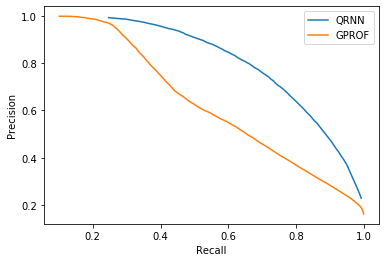

In [23]:
f, ax = plt.subplots(1, 1)
ax.plot(recall_qrnn, precision_qrnn, label="QRNN")
ax.plot(recall_gprof, precision_gprof, label="GPROF")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()